# Анализ пользовательского поведения в мобильном приложении

В качестве аналитика стартапа, который продаёт продукты питания, нужно разобраться, как ведут себя пользователи мобильного приложения. 
Следует изучить воронку продаж, узнать, как пользователи доходят до покупки, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно.
После этого нужно исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Требуется выяснить, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, можно быть уверенным в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

# Подготовка данных к анализу

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Таблица состоит из 4 столбцов и 244126 строк.

Первый столбец хранит информацию о названии действия, второй - id пользователя, третий - время события, а четвертый - номер эксперимента

In [4]:
data.duplicated().sum()

413

In [5]:
data = data.drop_duplicates().reset_index(drop=True)

In [6]:
data.columns = ['event_name', 'user_id', 'event_time', 'group']
data.head()

,event_name,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [7]:
data.isnull().sum()

event_name    0
user_id       0
event_time    0
group         0
dtype: int64

In [8]:
data['event_time'] = pd.to_datetime(data['event_time'], unit = 's')

In [9]:
data

,event_name,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


Добавьте столбец даты и времени, а также отдельный столбец дат

In [10]:
data['event_date'] = data['event_time'].dt.strftime('%Y-%m-%d')
data

,event_name,user_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


# Изучение и проверка данных

**Сколько всего событий в логе?**

In [11]:
data['event_name'].count() 

243713

Всего в логе 243713 событий 

In [12]:
data['event_name'].nunique()

5

Всего существует 5 видов событий

**Сколько всего пользователей в логе?**

In [13]:
data['user_id'].nunique()

7551

Всего в логе 7551 пользователей

**Сколько в среднем событий приходится на пользователя?**

In [14]:
data['event_name'].count() / data['user_id'].nunique()

32.27559263673685

В среднем на одного пользователя приходится 32,3 события

**Данными за какой период вы располагаете?**

In [15]:
data['event_time'].min()

Timestamp('2019-07-25 04:43:36')

In [16]:
data['event_time'].max()

Timestamp('2019-08-07 21:15:17')

Мы располагаем данными с 2019-07-25 по 2019-08-07

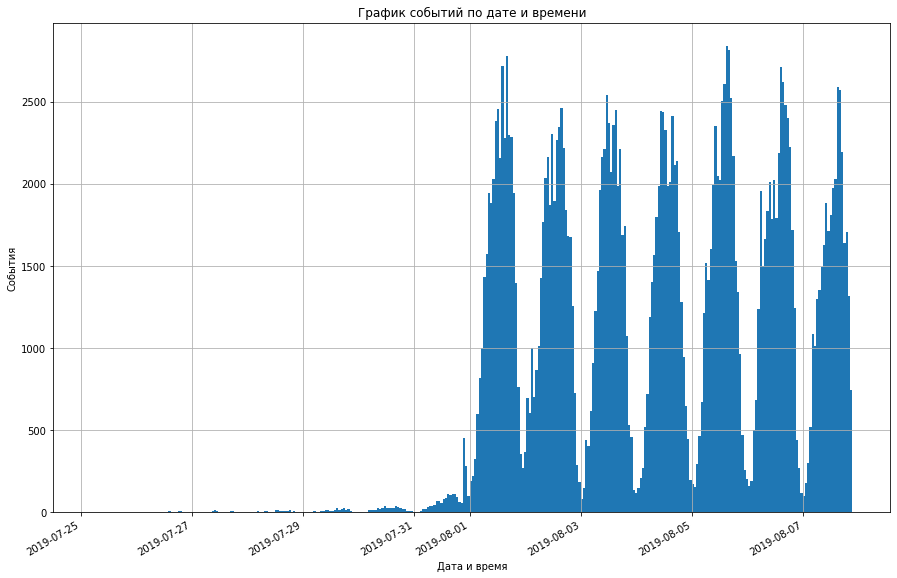

In [17]:
fig = plt.figure(figsize = (15, 10))
plt.title('График событий по дате и времени')
plt.xlabel('Дата и время')
plt.ylabel('События')
data['event_time'].hist(bins = 14*24)

fig.autofmt_xdate()

По графику видно, что актульные данные полные данные появились только 2019-08-01

In [18]:
data['event_time'][data['event_date'] >= '2019-08-02']

38967    2019-08-02 00:00:00
38968    2019-08-02 00:00:08
38969    2019-08-02 00:00:18
38970    2019-08-02 00:00:19
38971    2019-08-02 00:00:32
                 ...        
243708   2019-08-07 21:12:25
243709   2019-08-07 21:13:59
243710   2019-08-07 21:14:43
243711   2019-08-07 21:14:58
243712   2019-08-07 21:15:17
Name: event_time, Length: 204746, dtype: datetime64[ns]

<AxesSubplot:>

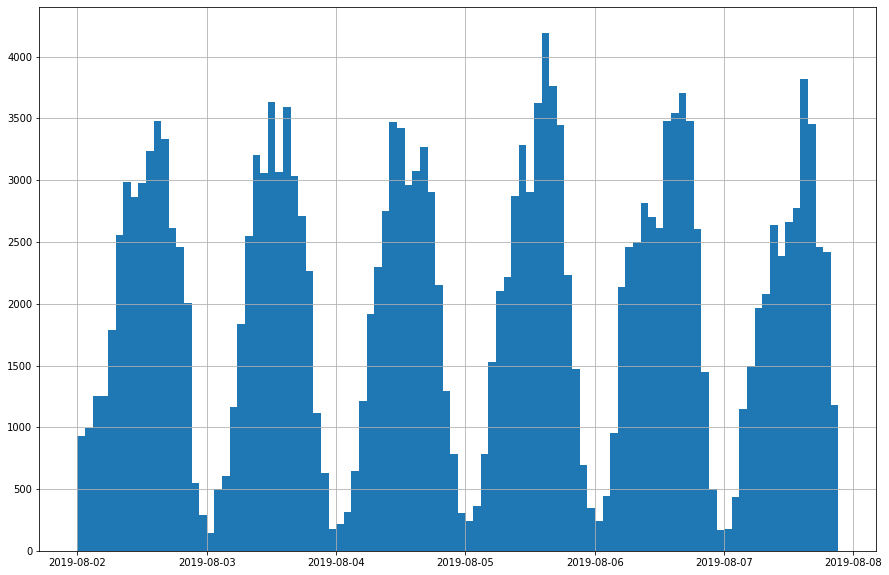

In [19]:
data['event_time'][data['event_date'] >= '2019-08-02'].hist(figsize = (15, 10), bins = 100)

<AxesSubplot:>

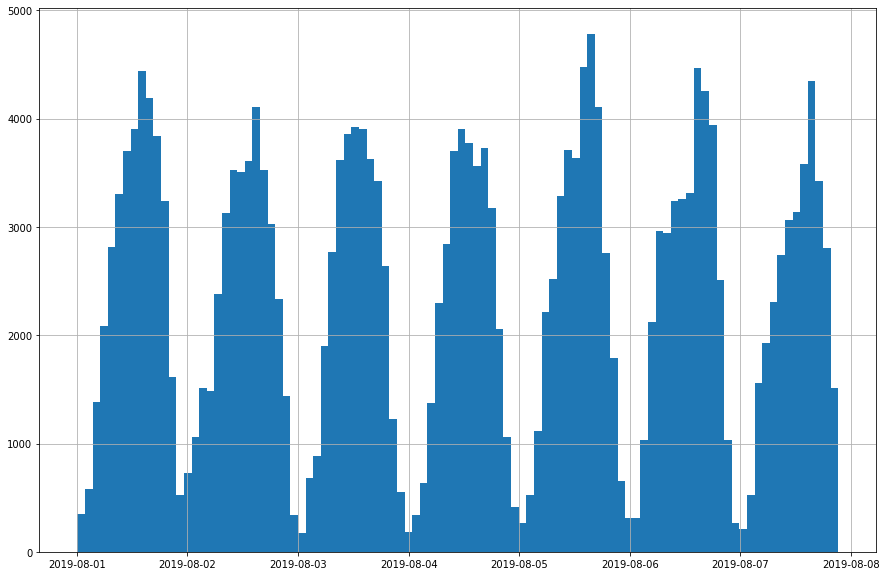

In [20]:
data['event_time'][data['event_date'] >= '2019-08-01'].hist(figsize = (15, 10), bins = 100)

<AxesSubplot:>

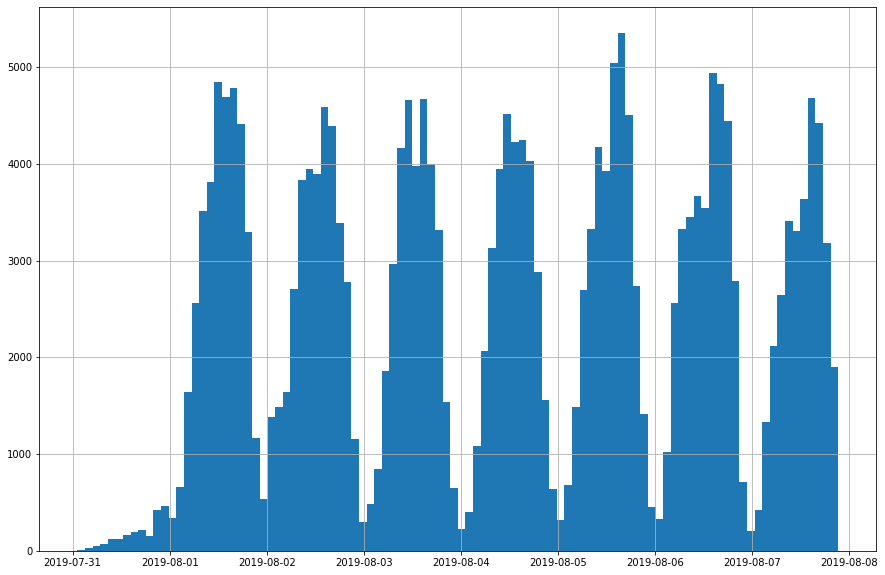

In [21]:
data['event_time'][data['event_date'] >= '2019-07-31'].hist(figsize = (15, 10), bins = 100)

Действительно, актуальные данные начинаются с 2019-08-01

**Много ли событий и пользователей вы потеряли, отбросив старые данные?**

In [22]:
data_new = data.query('event_date >= "2019-08-01"')
data_new

,event_name,user_id,event_time,group,event_date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [23]:
data['user_id'].nunique() - data_new['user_id'].nunique()

17

In [24]:
data_new['user_id'].nunique()/data['user_id'].nunique()*100 #ушло совсем незначительно количество пользователей

99.77486425638989

In [25]:
data['event_name'].nunique() - data_new['event_name'].nunique()

0

**Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.**

In [26]:
data_new = data.query('event_date >= "2019-08-01"')
data_new

,event_name,user_id,event_time,group,event_date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [27]:
data_new['group'].nunique()
#остались все 3 экспериментальные группы

3

# Изучите воронку событий

**Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.**

In [28]:
data_new.agg({'event_name': ['count', 'nunique']})

,event_name
count,240887
nunique,5


In [29]:
event_name_pivot = data_new.pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'count')
event_name_pivot
event_name_pivot.sort_values(by = 'user_id', ascending = False)

,user_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


**Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.**

In [30]:
users = data_new.groupby('event_name').agg({'user_id': 'nunique'})
users.sort_values(by = 'user_id', ascending = False)

,user_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [31]:
data_new['user_id'].nunique()

7534

In [32]:
users

,user_id
event_name,
CartScreenAppear,3734
MainScreenAppear,7419
OffersScreenAppear,4593
PaymentScreenSuccessful,3539
Tutorial,840


In [33]:
round((users/data_new['user_id'].nunique())*100, 2).sort_values(by = 'user_id', ascending = False)

,user_id
event_name,
MainScreenAppear,98.47
OffersScreenAppear,60.96
CartScreenAppear,49.56
PaymentScreenSuccessful,46.97
Tutorial,11.15


Из таблицы видно, какую долю составляют пользовтели по тем или иным действиям. Отметим, что очень мало людей проходя обучение

**Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.**

Судя по предыдущей таблице и доле пользователей для каждого события, порядок такой: MainScreenAppear(главнй экран), OffersScreenAppear(окно предложения), CartScreenAppear(экран корзины), PaymentScreenSuccessful(окно оплаты), Tutorial(обучение). Выглядит логично, хотя Tutorial вряд ли должен быть последним действием. Возможно, его просто пропускают

**По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.**

In [34]:
users = users.sort_values(by = 'user_id', ascending = False)
users

,user_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [35]:
users['ratio'] = (users['user_id']/users['user_id'].shift(1))*100
users

,user_id,ratio
event_name,,
MainScreenAppear,7419,NaN
OffersScreenAppear,4593,61.908613
CartScreenAppear,3734,81.297627
PaymentScreenSuccessful,3539,94.777718
Tutorial,840,23.735519


Вряд ли можно корректо оценивать Tutorial как заключительный этап. Смотря на другие этапы, можно сказать, что меньше всего пользователей переходят с главного экрана на страницу предложения.

**На каком шаге теряете больше всего пользователей?**

Больше всего пользователей теряется при переходе с главного экрана на страницу предложения (примерно 19,4%)

**Какая доля пользователей доходит от первого события до оплаты?**

In [36]:
3539/7419*100

47.70184661005526

От первого события(MainScreenAppear) и до оплаты(PaymentScreenSuccessful) доходят только 47,7% пользователей

# Изучите результаты эксперимента

In [37]:
data_new = data.query('event_name != "Tutorial"')
data_new = data.query('event_date >= "2019-08-01"')
#уберем этап Tutorial из анализа

**Сколько пользователей в каждой экспериментальной группе?**

In [38]:
data.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
246,2489
247,2520
248,2542


In [39]:
groups = data_new.groupby('group').agg({'user_id': 'nunique'})
groups

,user_id
group,
246,2484
247,2513
248,2537


**Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?**

Самое популярное событие - MainScreenAppear

In [40]:
events_groups = data_new.groupby(['group', 'event_name']).agg({'user_id': 'nunique'})
events_groups=events_groups.query('event_name == "MainScreenAppear"')
events_groups=events_groups.query('group != 248')
events_groups

,,user_id
group,event_name,
246,MainScreenAppear,2450
247,MainScreenAppear,2476


In [41]:
#7534 - количество всех пользовтаелей 
events_groups['proportion'] = events_groups['user_id']/7534*100
events_groups
#доля пользователей, совершивших событие MainScreenAppear для группы 246 = 32,6%, а для группы 247 = 32,9%

,,user_id,proportion
group,event_name,,
246,MainScreenAppear,2450,32.519246
247,MainScreenAppear,2476,32.864348


In [42]:
events_groups = data_new.groupby(['group', 'event_name']).agg({'user_id': 'nunique'})
events_groups=events_groups.query('group != 248')
events_groups

events_groups['proportion'] = events_groups['user_id']/7534*100
events_groups.sort_values(by = 'event_name')

,,user_id,proportion
group,event_name,,
246,CartScreenAppear,1266,16.803823
247,CartScreenAppear,1238,16.432174
246,MainScreenAppear,2450,32.519246
247,MainScreenAppear,2476,32.864348
246,OffersScreenAppear,1542,20.467215
247,OffersScreenAppear,1520,20.175206
246,PaymentScreenSuccessful,1200,15.927794
247,PaymentScreenSuccessful,1158,15.370321
246,Tutorial,278,3.689939


In [43]:
groups #всего пользователей

,user_id
group,
246,2484
247,2513
248,2537


In [44]:
groups_pivot = data_new.pivot_table(index = 'event_name', values = 'user_id', columns='group', aggfunc = 'nunique')
groups_pivot = groups_pivot.query('event_name != "Tutorial"')
groups_pivot.columns = ['gr246', 'gr247', 'gr248']
groups_pivot['246+247'] = groups_pivot['gr246'] + groups_pivot['gr247']
groups_pivot.columns = ['gr246', 'gr247', 'gr248', 'gr246_247']
groups_pivot['all_246'] = 2484
groups_pivot['all_247'] = 2513
groups_pivot['all_248'] = 2537
groups_pivot['all_gr246_247'] = 2484+2513


groups_pivot

,gr246,gr247,gr248,gr246_247,all_246,all_247,all_248,all_gr246_247
event_name,,,,,,,,
CartScreenAppear,1266,1238,1230,2504,2484,2513,2537,4997
MainScreenAppear,2450,2476,2493,4926,2484,2513,2537,4997
OffersScreenAppear,1542,1520,1531,3062,2484,2513,2537,4997
PaymentScreenSuccessful,1200,1158,1181,2358,2484,2513,2537,4997


In [45]:
groups_pivot.columns

Index(['gr246', 'gr247', 'gr248', 'gr246_247', 'all_246', 'all_247', 'all_248',
       'all_gr246_247'],
      dtype='object')

In [46]:
groups_pivot.index

Index(['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful'],
      dtype='object', name='event_name')

Нулвеая гипотеза: между долями есть занчимая разница; альтернативная гипотеза: между долями нет значимой разницы

In [47]:
def z_test(event_1, event_2, total_1, total_2, alpha):
    share_1 = event_1 / total_1
    share_2 = event_2 / total_2
    share_combined = (event_1 + event_2) / (total_1 + total_2)
    diff = share_1 - share_2

    z_value = diff / (share_combined * (1 - share_combined) * (1/total_1 + 1/total_2)) ** 0.5
    dist = st.norm(0, 1)
    p_value = 2 * (1 - dist.cdf(abs(z_value)))
    
    if (p_value < alpha):
            print("Отвергаем нулевую гипотезу, т.к. между долями есть значимая разница")
    else:
            print("Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными")
       

In [48]:
for i in groups_pivot.index:
    print (i, z_test(groups_pivot.loc[i, 'gr246'], groups_pivot.loc[i, 'gr247'], groups_pivot.loc[i, 'all_246'], groups_pivot.loc[i, 'all_247'], 0.05))
    print('**********')

Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
CartScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
MainScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
OffersScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
PaymentScreenSuccessful None
**********


Во обеих контрольных группах при всех действиях нет оснований считать доли разными

--------------

**Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?**



Нулвеая гипотеза: между долями есть занчимая разница; альтернативная гипотеза: между долями нет значимой разницы

In [49]:
for i in groups_pivot.index:
    print (i, z_test(groups_pivot.loc[i, 'gr246'], groups_pivot.loc[i, 'gr248'], groups_pivot.loc[i, 'all_246'], groups_pivot.loc[i, 'all_248'], 0.05))
    print('**********')

Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
CartScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
MainScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
OffersScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
PaymentScreenSuccessful None
**********


Во обеих группах при всех действиях нет оснований считать доли разными

In [50]:
for i in groups_pivot.index:
    print (i, z_test(groups_pivot.loc[i, 'gr247'], groups_pivot.loc[i, 'gr248'], groups_pivot.loc[i, 'all_247'], groups_pivot.loc[i, 'all_248'], 0.05))
    print('**********')

Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
CartScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
MainScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
OffersScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
PaymentScreenSuccessful None
**********


Во обеих группах при всех действиях нет оснований считать доли разными

In [51]:
for i in groups_pivot.index:
    print (i, z_test(groups_pivot.loc[i, 'gr246_247'], groups_pivot.loc[i, 'gr248'], groups_pivot.loc[i, 'all_gr246_247'], groups_pivot.loc[i, 'all_248'], 0.05))
    print('**********')

Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
CartScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
MainScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
OffersScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
PaymentScreenSuccessful None
**********


При сравнении результатов экспериментальной с объединённой контрольной группой также нет оснований считать доли разными со всеми действиями.

--------------

**Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.**

In [52]:
for i in groups_pivot.index:
    print (i, z_test(groups_pivot.loc[i, 'gr246'], groups_pivot.loc[i, 'gr248'], groups_pivot.loc[i, 'all_246'], groups_pivot.loc[i, 'all_248'], 0.1))
    print('**********')

Отвергаем нулевую гипотезу, т.к. между долями есть значимая разница
CartScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
MainScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
OffersScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
PaymentScreenSuccessful None
**********


Лишь в случае с CartScreenAppear между долями наблюдается значимая разница

In [53]:
for i in groups_pivot.index:
    print (i, z_test(groups_pivot.loc[i, 'gr247'], groups_pivot.loc[i, 'gr248'], groups_pivot.loc[i, 'all_247'], groups_pivot.loc[i, 'all_248'], 0.1))
    print('**********')

Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
CartScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
MainScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
OffersScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
PaymentScreenSuccessful None
**********


Во обеих группах при всех действиях нет оснований считать доли разными

In [54]:
for i in groups_pivot.index:
    print (i, z_test(groups_pivot.loc[i, 'gr246_247'], groups_pivot.loc[i, 'gr248'], groups_pivot.loc[i, 'all_gr246_247'], groups_pivot.loc[i, 'all_248'], 0.1))
    print('**********')

Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
CartScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
MainScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
OffersScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
PaymentScreenSuccessful None
**********


При сравнении результатов экспериментальной с объединённой контрольной группой также нет оснований считать доли разными со всеми действиями.

In [55]:
for i in groups_pivot.index:
    print (i, z_test(groups_pivot.loc[i, 'gr246'], groups_pivot.loc[i, 'gr248'], groups_pivot.loc[i, 'all_246'], groups_pivot.loc[i, 'all_248'], 0.5))
    print('**********')

Отвергаем нулевую гипотезу, т.к. между долями есть значимая разница
CartScreenAppear None
**********
Отвергаем нулевую гипотезу, т.к. между долями есть значимая разница
MainScreenAppear None
**********
Отвергаем нулевую гипотезу, т.к. между долями есть значимая разница
OffersScreenAppear None
**********
Отвергаем нулевую гипотезу, т.к. между долями есть значимая разница
PaymentScreenSuccessful None
**********


Во обеих группах при всех действиях между долями есть значимая разница

In [56]:
for i in groups_pivot.index:
    print (i, z_test(groups_pivot.loc[i, 'gr247'], groups_pivot.loc[i, 'gr248'], groups_pivot.loc[i, 'all_247'], groups_pivot.loc[i, 'all_248'], 0.5))
    print('**********')

Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
CartScreenAppear None
**********
Отвергаем нулевую гипотезу, т.к. между долями есть значимая разница
MainScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
OffersScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
PaymentScreenSuccessful None
**********


Во обеих группах лишь при MainScreenAppear между долями есть значимая разница

In [57]:
for i in groups_pivot.index:
    print (i, z_test(groups_pivot.loc[i, 'gr246_247'], groups_pivot.loc[i, 'gr248'], groups_pivot.loc[i, 'all_gr246_247'], groups_pivot.loc[i, 'all_248'], 0.5))
    print('**********')

Отвергаем нулевую гипотезу, т.к. между долями есть значимая разница
CartScreenAppear None
**********
Отвергаем нулевую гипотезу, т.к. между долями есть значимая разница
MainScreenAppear None
**********
Отвергаем нулевую гипотезу, т.к. между долями есть значимая разница
OffersScreenAppear None
**********
Не получилось отвергнуть нулевую гипотезу, т.к. нет оснований считать доли разными
PaymentScreenSuccessful None
**********


При сравнении результатов экспериментальной с объединённой контрольной группой нет оснований считать доли разными лишь при PaymentScreenSuccessful 


При alpha = 0.5 при сравнении контрольной группы 246 и экспериментальной группы по всем действиям наблюдается значимая разница между долями; При alpha = 0.5 при сравнении контрольной группы 247 и экспериментальной группы по всем действиям нет оснований считать доли разными кроме MainScreenAppear, тут между долями есть значимая разница; При alpha = 0.5 при сравнении объединённой контрольной группы и экспериментальной группы лишь при PaymentScreenSuccessful нет оснований считать доли разными, а по MainScreenAppear, OffersScreenAppear и CartScreenAppear между долями есть значимая разница. Стоит отметить, что 0.5 - это слишком много для alpha.

# Выводы

Всего событий: 243713;
В логе присутсвует 5 разных видов событий: MainScreenAppear(главнй экран), OffersScreenAppear(окно предложения), CartScreenAppear(экран корзины), PaymentScreenSuccessful(окно оплаты), Tutorial(обучение);
Количество уникальных пользователей: 7551;
В среднем на одного пользователя приходится 32,3 события;
Полные актуальные данные появляются 2019-08-01, а заканчиваются 2019-08-07;
Самое популярное событие - MainScreenAppear;
Tutorial исключили из анализа, т.к. оно встречается крайне редко, а также оно слабо вписывается в следующую поледовательность: MainScreenAppear(главнй экран), OffersScreenAppear(окно предложения), CartScreenAppear(экран корзины), PaymentScreenSuccessful(окно оплаты).

Было проведено несколько проверок статистических гипотез с уровнем значимости 0.05, однако ни одна из них не выявила значимой разницы. При уровнем значимости 0.1 лишь при сранении контрольной группы 246 и экспериментальной группы в случае с CartScreenAppear между долями наблюдается значимая разница, а во всех остальных случаях ни одна из проверок не выявила значимой разницы.
При alpha = 0.5 при сравнении контрольной группы 246 и экспериментальной группы по всем действиям наблюдается значимая разница между долями; При alpha = 0.5 при сравнении контрольной группы 247 и экспериментальной группы по всем действиям нет оснований считать доли разными кроме MainScreenAppear, тут между долями есть значимая разница; При alpha = 0.5 при сравнении объединённой контрольной группы и экспериментальной группы лишь при PaymentScreenSuccessful нет оснований считать доли разными, а по MainScreenAppear, OffersScreenAppear и CartScreenAppear между долями есть значимая разница.

Исходя из всех результатов A/A/B-теста можно сказать, что изменение шрифта особого эффекта не имеет. Следовательно, изменение шрифта вряд ли отпугнет пользователей.